# Demo de  Deep Convolutional Generative Adversarial Networks (GAN) de Wasserstein con Gradient Penalty  para generar imágenes
Basado en:

 https://keras.io/examples/generative/wgan_gp/

 https://keras.io/examples/generative/gan_ada/#gan-tips-and-tricks

 https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b


In [1]:
#@title Define Keras BackEnd como TF
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [2]:
#@title Librerías a usar
import tensorflow as tf
import keras
from keras import layers


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import pandas as pd


import random
import copy
import os

import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import display

from PIL import Image

print("\nLibrerías importadas")


Librerías importadas


# Imágenes:

In [3]:
#@title Acceder al Drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demoML/imagenes/NUMEROS' #@param {type:"string"}
path_entrenamiento = '/train'  #@param {type:"string"}
#@markdown - Nota: no se usan las imágenes de prueba.
#path_prueba = '/test'  #@param {type:"string"}

imagPath_train = path + path_entrenamiento
#imagPath_test = path + path_prueba

Mounted at /content/gdrive


> Para Entrenamiento: 
- Clases cargadas:  10
- Imágenes cargadas:  240
- Ejemplo  4   (32, 32) : 


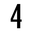

In [5]:
#@title Cargar imágenes


#@markdown ### Parámetros para imágenes fijos: [32 x 32 x 1]
imagen_ancho = 32 #param {type:"integer"}
imagen_largo = 32 #param {type:"integer"}
imagen_color = False #param {type:"boolean"}


# tamaño de las imágenes
if imagen_ancho<=10:
  imagen_largo = 10
if imagen_largo<=10:
  imagen_largo = 10
IMAGE_SHAPE = (imagen_ancho, imagen_largo, (3 if imagen_color else 1))

# define función para cargar las imágenes
def cargarImagenes(imagPath):
  classes_ori = []
  images_ori = []

  all_dirs = os.listdir( imagPath )
  for each_dir in all_dirs:

      auxiPath = imagPath + '/' + each_dir
      imagFN  = os.listdir( auxiPath )
      for each_imagFN in imagFN:


            # abre la imagen
            imag = Image.open(auxiPath + "/" + each_imagFN)

            # ajusta el tamaño
            if IMAGE_SHAPE[2]==1:
              tipoImage = 'L'
            else:
              tipoImage = 'RGB'
            imag = imag.convert(tipoImage)
            imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.LANCZOS)

            # transforma a un vector de nros
            arImag = np.array(imag)

            # agrega a los vectores
            classes_ori.append( each_dir )
            images_ori.append( arImag )

  return classes_ori, images_ori, tipoImage

# carga las imagenes de entrenamiento
classes_train, images_train, tipoImage_train = cargarImagenes(imagPath_train)
print("> Para Entrenamiento: ")
print("- Clases cargadas: ", len(np.unique(classes_train)))
print("- Imágenes cargadas: ", len(classes_train))

if len(classes_train)>0:
  print("- Ejemplo ", classes_train[0], " ", images_train[0].shape, ": ")
  display( Image.fromarray(images_train[0], tipoImage_train) )


### # carga las imagenes de prueba
### classes_test, images_test, tipoImage_test = cargarImagenes(imagPath_test)
### print("\n\n> Para Prueba: ")
### print("- Clases cargadas: ", len(np.unique(classes_test)))
### print("- Imágenes cargadas: ", len(images_test))

### if len(classes_test)>0:
###   print("- Ejemplo ", classes_test[0], " ", images_test[0].shape, ": ")
###   display( Image.fromarray(images_test[0], tipoImage_test) )



> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (240, 32, 32, 1)
 - y_trainEnc (cant):  240
 - y_train (cant):  240

 - Imagen reconstruida de  4 ( 8  /  8 )


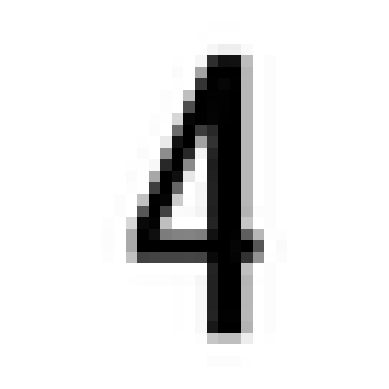

In [6]:
#@title Preparar imágenes para usar en el modelo

# define función auxiliar para mostrar imágenes preparadas
def plot_image(imag):
  imag = (imag * 127.5) + 127.5
  if IMAGE_SHAPE[2]==1:
    plt.imshow((imag).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]).astype(np.uint8))
    plt.gray()
  else:
    plt.imshow((imag).reshape(IMAGE_SHAPE).astype(np.uint8))
  plt.axis("off")

# define función auxiliar para preparar la lista de imágenes a procesar
def prepare_imageList(imagList):
  auxiAr = np.array(imagList).astype('float32')
  auxiAr = (auxiAr - 127.5) / 127.5
  auxiAr = auxiAr.reshape((len(auxiAr), IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))
  return auxiAr

# define función auxiliar para preparar lista de clases
def prepare_clasesList(classesList, dictMapeo=None):
  if dictMapeo==None:
    # genera diccionario de mapeo
    auxDict = list(set(classesList))
    dictMapeo = dict( zip( auxDict, range(len(auxDict)) ) )
  # realiza el mapeo
  y = []
  for cl in classesList:
      y.append( dictMapeo[cl] )
  # convierte valores numéricos a columnas de vakores binarios (i.e. one hot encoded)
  #dummy_y = to_categorical(y)
  dummy_y = y
  # devuelve
  return np.array(y), np.array(dummy_y), dictMapeo

# define vector auxiliar de datos de entrada para usar en el entrenamiento y prueba
x_train = prepare_imageList(images_train)
##x_test = prepare_imageList(images_test)

# define vector auxiliar de datos de salida para usar en el entrenamiento y prueba
# también usa esta información para determinar la cantida de neuronas de salida
y_train, y_trainEnc, dictMapeo = prepare_clasesList(classes_train)
##y_test, y_testEnc,_ = prepare_clasesList(classes_test, dictMapeo)

# genera diccionario auxiliar para poder convertir de ID de clase a nombre de clase
clases_map = [ x for x,y in dictMapeo.items() ]

print("> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_trainEnc (cant): ", len(y_trainEnc))
print(" - y_train (cant): ", len(y_train))
'''
print("\n\n> Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_testEnc (cant): ", len(y_testEnc))
print(" - y_test (cant): ", len(y_test))
print("\n\n> Para Ambos: ")
print(" - dictMapeo: ", dictMapeo)
print(" - clases_map: ", clases_map)
'''
if len(y_train)>0:
  print("\n - Imagen reconstruida de ", clases_map[y_train[0]],  "(", y_train[0], " / ", y_trainEnc[0], ")")
  plot_image(x_train[0])

# Modelo:

In [23]:
#@title Establecer modelo GAN

# Size of the noise vector
noise_dim = 128

# discriminator model
print("")
def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_discriminator_model():
    img_input = layers.Input(shape=IMAGE_SHAPE)
    # Zero pad the input to make the input images size to (32, 32, 1).
    x = layers.ZeroPadding2D((2, 2))(img_input)
    x = conv_block(
        x,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model

d_model = get_discriminator_model()
d_model.summary()


# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss



# generator model
print("")
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))
    x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((4, 4, 256))(x)
    x = upsample_block(
        x,
        128,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        64,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x, 1, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )
    '''
    # At this point, we have an output which has the same shape as the input, (32, 32, 1).
    # We will use a Cropping2D layer to make it (28, 28, 1).
    x = layers.Cropping2D((2, 2))(x)
    '''

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model

g_model = get_generator_model()
g_model.summary()


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# WGAN-GP model
print("")
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}


# Train the end-to-end model
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)


# Get the wgan model
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile the wgan model
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)


# function to create image
def generate_images(wgan, quantity=1):
  if quantity<1:
    quantity = 1
  # se genera las imágenes
  random_latent_vectors = tf.random.normal(shape=(quantity, wgan.latent_dim))
  generated_images = wgan.generator(random_latent_vectors)
  # se formatean las imágenes
  generated_images = (generated_images * 127.5) + 127.5
  res_images = []
  for img in generated_images:
    img = img.numpy()
    img = keras.utils.array_to_img(img)
    res_images.append( img )
  return res_images

print("Clase WGAN definida.")

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_4 (ZeroPadding2D)     │ (None, 36, 36, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 18, 18, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_28 (LeakyReLU)           │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 9, 9, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_29 (LeakyReLU)           │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 5, 5, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_30 (LeakyReLU)           │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 3, 3, 512)           │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_31 (LeakyReLU)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │           4,609 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,307,969 (16.43 MB)

 Trainable params: 4,307,969 (16.43 MB)

 Non-trainable params: 0 (0.00 B)

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4096)                │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 4096)                │          16,384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_32 (LeakyReLU)           │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_12 (UpSampling2D)      │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 8, 8, 128)           │         294,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_33 (LeakyReLU)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_13 (UpSampling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 16, 16, 64)          │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_34 (LeakyReLU)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_14 (UpSampling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 32, 32, 1)           │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 32, 32, 1)           │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 32, 32, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 910,660 (3.47 MB)

 Trainable params: 902,082 (3.44 MB)

 Non-trainable params: 8,578 (33.51 KB)


Clase WGAN definida.


In [24]:
#@title Entrenar GAN

cant_epocas_entrenamiento =  300 #@param {type:"integer"}
cant_img_generar_por_epoca =  5 #@param {type:"integer"}

# cantidad de épocas del entrenamiento
cantEpocas = (1 if cant_epocas_entrenamiento<1 else cant_epocas_entrenamiento)
cant_img_generar_por_epoca = (1 if cant_img_generar_por_epoca<1 else cant_img_generar_por_epoca)


# Create a Keras callback that periodically saves generated images
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=1):
        self.num_img = num_img
        self.gen_imagFN_list = {}

    def on_epoch_end(self, epoch, logs=None):
        global imag_generated_training
        epoch += 1 # arranca en cero
        self.gen_imagFN_list[epoch] = []
        generated_images = generate_images(self.model, quantity=self.num_img)
        i = 0
        for img in generated_images:
            i = i + 1
            fn = "epoch_{epoch}_img_{i}.png".format(i=i, epoch=epoch)
            img.save(fn)
            self.gen_imagFN_list[epoch].append( fn )


# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_img=cant_img_generar_por_epoca)

# Start training
print("\n\n>Comienza el Entrenamiento:")

history = wgan.fit(x_train,
         epochs=cant_epocas_entrenamiento,
         callbacks=[cbk])

print("\n>Entrenamiento Finalizado.")



>Comienza el Entrenamiento:
Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - d_loss: -26.8008 - g_loss: -3.0520
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - d_loss: -34.6590 - g_loss: -4.5052
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - d_loss: -33.5275 - g_loss: -4.8026
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - d_loss: -31.4927 - g_loss: -9.2075
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - d_loss: -31.2059 - g_loss: -11.0101
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - d_loss: -30.7649 - g_loss: -14.9043
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - d_loss: -30.5464 - g_loss: -18.0089
Epoch 8/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - d_loss: -29.6598 - g_loss: -20.0931
Epoch 9/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - d_loss: -29.1546 - g_loss: -24.9741
Epoch 10/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - d_loss: -28.3711 - g_loss: -26.8499
Epoch 11/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - d_loss: -28.0361 - g_loss: -29.2571

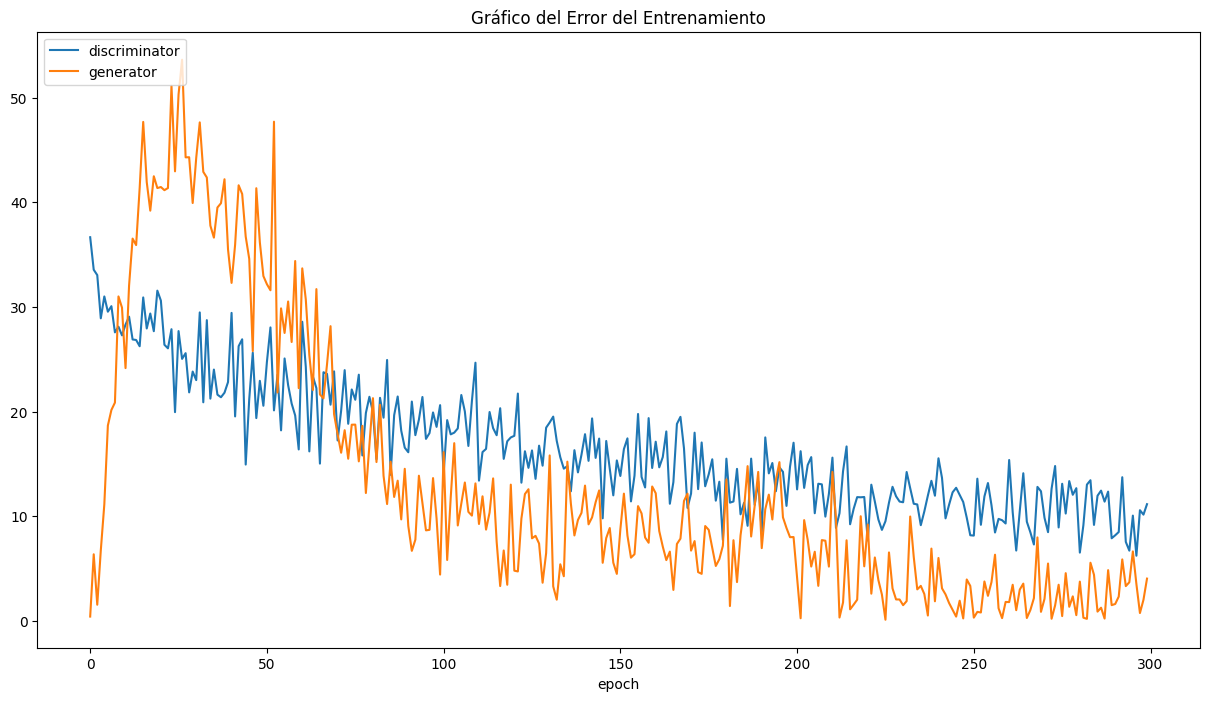

In [25]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8))
# toma valor absoluto del loss para que se muestre que baja
plt.plot(np.abs(history.history['d_loss']))
plt.plot(np.abs(history.history['g_loss']))
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['discriminator', 'generator'], loc='upper left')
plt.show()


In [26]:
#@title Mostrar evolución de imágenes generadas durante entrenamiento
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib

# para que no se quede sin memoria
matplotlib.rcParams['animation.embed_limit'] = 3**128

# función para mostrar las imágenes de un epoch
def gen_images_epoch(ep):
    # arma la grilla para mostrar imágenes
    cantImgMostrar = len(ImagFN_epoch[ep])
    grid_row = 1
    grid_col = 5
    if grid_col < cantImgMostrar:
      grid_row += (cantImgMostrar//grid_col)
    f, axarr = plt.subplots(
        grid_row, grid_col, figsize=(grid_col * 2, grid_row * 2)
    )
    if grid_row>1:
      ax = axarr[row]
    else:
      ax = axarr
    row = 0
    col = 0
    ax[col].set_title("Epoch #"+str(ep), fontsize=11 )
    for imFN in ImagFN_epoch[ep]:
        img = Image.open(imFN)
        ax[col].imshow(img, animated=True)
        ax[col].axis("off")
        col += 1
        if col >= grid_col:
          row += 1
          col = 0
          if grid_row>1:
            ax = axarr[row]
          else:
            ax = axarr
    # oculta ejes en blanco
    if col < grid_col:
      for i in range(col, grid_col):
          ax[i].axis("off")
    fn = "grid_epoch_{epoch}.png".format(epoch=ep)
    plt.tight_layout()
    f.savefig(fn)
    plt.close(f)
    return fn

# obtiene las imágenes generadas por epoca
ImagFN_epoch = cbk.gen_imagFN_list
listEpochs = list(ImagFN_epoch.keys())

# genera imágenes en  grilla por época
image_array = []
for ep in listEpochs:
    fn = gen_images_epoch(ep)
    image = Image.open(fn)
    image_array.append(image)


# genera animación
fig, ax = plt.subplots()

im = ax.imshow(image_array[0], animated=True)

def update(i):
    im.set_array(image_array[i])
    return im,

animation_fig = animation.FuncAnimation(fig, update,
                                        frames=len(image_array), interval=len(image_array),
                                        blit=True, repeat=False)
plt.axis("off")
plt.tight_layout()
plt.close(fig)

# Nota: esto se agega para que funcione en Google Colab
rc('animation', html='jshtml')
display(animation_fig)


Output hidden; open in https://colab.research.google.com to view.

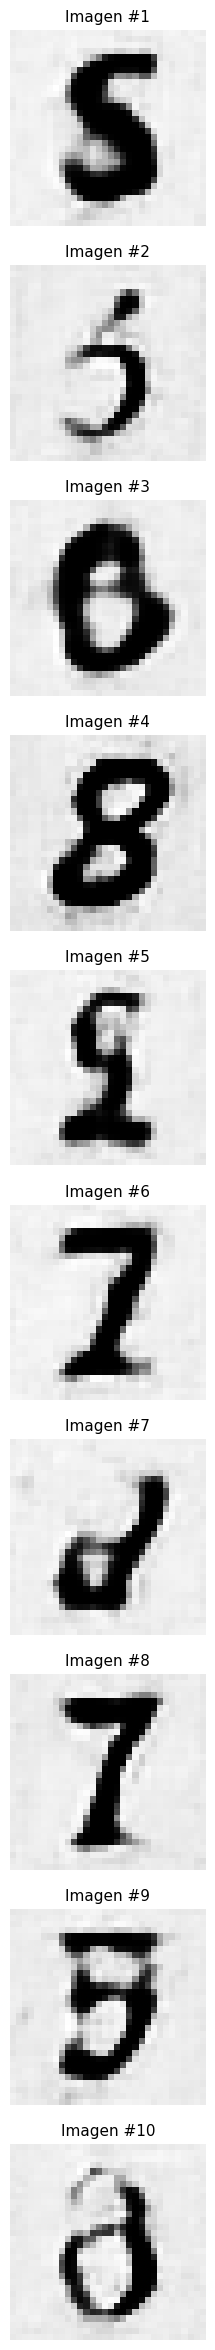

In [29]:
#@title Probar WAN generando nuevas imágenes
cant_img_generar = 10 #@param {type:"integer"}

# cantidad de épocas del entrenamiento
cant_img_generar = (1 if cant_img_generar<1 else cant_img_generar)

# arma la grilla para mostrar imágenes
grid_row = cant_img_generar
grid_col = 1
f, axarr = plt.subplots(
    grid_row, grid_col, figsize=(grid_col * 3, grid_row * 3)
)

generated_images = generate_images(wgan, quantity=cant_img_generar)
for i in range(len(generated_images)):
  axarr[i].set_title("Imagen #"+str(i+1), fontsize=11 )
  axarr[i].imshow(generated_images[i])
  axarr[i].axis("off")


In [ ]:
#@title Guardar Modelo entrenado

guardar_modelo = True #@param{type:"boolean"}
path_modelo = '/content/gdrive/MyDrive/IA/demoML/modelos/ImagGAN'  #@param {type:"string"}


if guardar_modelo:

    import joblib
    import os

    # si no existe el directorio, lo crea
    if not os.path.isdir(path_modelo):
      os.makedirs(path_modelo)

    # guarda el modelo entrenado
    fn_modelo = path_modelo + "/WGAN.joblib"
    joblib.dump(wgan, fn_modelo)
    print("\n-Funcion WGAN guardada en ", fn_modelo,"\n")

    # guarda el modelo entrenado
    fn_modelo = path_modelo + "/gan_generate_images.joblib"
    joblib.dump(generate_images, fn_modelo)
    print("\n-Funcion gan_generate_images guardada en ", fn_modelo,"\n")

    if ("IMAGE_SHAPE" in locals()) and (IMAGE_SHAPE is not None):
      fn_imageShape = path_modelo+"/IMAGE_SHAPE.txt"
      with open(fn_imageShape, 'w') as f:
        for i in IMAGE_SHAPE:
          f.write(str(i)+"\n")
      print("\n-IMAGE_SHAPE para cargar las imágenes guardado en ", path_modelo,"\n")

else:
    print("\n-Modelo no guardado.")